In [1]:
import cv2 as cv
import numpy as np
import skimage.io as io
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
import math
from skimage.color import rgb2gray,rgb2hsv,gray2rgb
from skimage.feature import canny

In [2]:
#input : frame ,initial background with no human in it
#output: binary image 
def segmentation (frame,background):
    diff = cv.absdiff(frame, background)
    gray = cv.cvtColor(diff, cv.COLOR_BGR2GRAY)
    x,y = gray.shape
    gray[gray > 35] = 255
    gray[gray <= 35] = 0
    return gray

In [3]:
#input binary image
#output array with border points
def border_extraction(img):
    #erosion = cv.erode(img, None, iterations=2)
    Human = cv.dilate(img, None, iterations=5)
    HumanEroded = cv.erode(Human, None, iterations=2)
    io.imshow(HumanEroded,cmap="gray")
    io.show()
    #border = cv.absdiff(Human, HumanEroded) 
    #return np.where(border==[255])
    border = canny(HumanEroded,low_threshold=50,high_threshold=200,sigma=0)

    io.imshow(border,cmap="gray")
    io.show()
    #return np.where(border== True)
    #borders with find contours
    pic_bin = img.astype('uint8')
    i,contours, hierarchy = cv.findContours(pic_bin,mode=cv.RETR_EXTERNAL,method=cv.CHAIN_APPROX_SIMPLE)
    black=np.copy(img*0)
    cv.drawContours(black, contours, -1, (255,255,255), 2)
    black = rgb2gray(black)
    io.imshow(black,cmap="gray")
    io.show()

    return np.where(black==[255])

In [16]:
#input border points
#output centroid, star points, distances from centroid to star points
def star(indices,img):

    xc = 0
    yc = 0
    size = len(indices[0])

    x = indices[1]
    xc = int(sum(x)/size)
    x = pow(x-xc,2)

    y = indices[0]
    yc = int(sum(y)/size)
    y = pow(y-yc,2)
    def f(x):
        return (math.sqrt(x))
    f2 = np.vectorize(f)
    signal =f2(x+y)
    filtered_signal= scipy.ndimage.gaussian_filter1d(signal, 10)
    
    #filtered_signal = np.concatenate((np.array([0]),filtered_signal,(np.array([0]))))
    
    plt.plot(signal, label='unfiltered signal')
    plt.legend()
    plt.grid()
    plt.show()
    plt.plot(filtered_signal, label='filtered signal, sigma=3')
    plt.legend()
    plt.grid()
    plt.show()

    peaks_indx = scipy.signal.find_peaks(filtered_signal)

    indx = (filtered_signal[peaks_indx[0]].tolist())

    #star_out = np.array([indices[0][indx],indices[1][indx]])
    star_out=np.array([])
    #print(star_out)

    for i in range(len(peaks_indx[0])):
        
    #print(indices[0][peaks_indx[i]])

        z = indices[1][peaks_indx[0][i]]
    #print(z)
        w = indices[0][peaks_indx[0][i]]
    #print(w)
        point = (z,w)
    #print(point)
        cv.circle(img,point,10,(255,0,0),2)
        star_out = np.concatenate((star_out,np.array(point)))
    cv.circle(img,(xc,yc),10,(255,0,0),2)
    io.imshow(img)
    io.show()

    
    return np.array([xc,yc]),star_out.reshape(-1,2)


In [34]:
def getAngles(stars,xc,yc):
    angle=np.zeros(2)
    angle[0]=math.degrees( math.atan2(stars[2][1]-yc, stars[2][0] -xc) - math.atan2(stars[0][1]-yc,stars[0][0]-xc))
    if(angle[0]<0):
        angle[0]=angle[0]+360
    angle[1] = math.degrees(   math.atan2(stars[1][1]-yc,stars[1][0]-xc)-math.atan2(stars[2][1]-yc, stars[2][0] -xc))
    if(angle[1]<0):
        angle[1]=angle[1]+360
    return angle

In [37]:
def getAngle(arm,head,xc,yc):
    angle=np.zeros(1)
    angle[0]=math.degrees( math.atan2(head[1]-yc, head[0] -xc) - math.atan2(arm[1]-yc,arm[0]-xc))
    if(angle[0]<0):
        angle[0]=angle[0]+360
    return angle

In [38]:
def distinguish_points(star_points):
    #get head and both arms
    return star_points[0],star_points[1],star_points[2]

In [41]:
def detect_right_hand (right_cluster,right_arm,right_angle):
    return 1
    #return which label


In [40]:
def detect_left_hand (left_cluster,left_arm,left_angle):
    return 1
    #return which label


In [42]:
def detect_pose(right_pose,left_pose,target_pose):
    return false

In [45]:
def resiz(stars,xc,yc,model,height):
    dist=distance(stars,xc,yc)
    factor= model/height
    leftNew = dist[0]*factor
    rightNew= dist[1]*factor
    diff1=leftNew-dist[0]
    diff2=rightNew-dist[1]
    v1=np.zeros(2)
    v2=np.zeros(2)
    v1[0]=stars[0][0][0]-xc
    v1[1]=stars[0][0][1]-yc
    v2[0]=stars[1][0][0]-xc
    v2[1]=stars[1][0][1]-yc
    vNorm1=v1/dist[0]
    vNorm2=v2/dist[1]
    newLeft= stars[0][0]+(diff1*vNorm1)
    newRight= stars[1][0]+(diff2*vNorm2)
    stars[0][0]=newLeft
    stars[1][0]=newRight
    

In [46]:
#collective function
def functions_sequence (): 
    #get the background and keep it
    #call get a frame and call sequence of functions
    
    #segmentation step
    im1 = io.imread ("pictures/T.1.jpg")
    im2 = io.imread ("pictures/T.1_back.jpg")
    io.imshow(im1)
    io.show()
    io.imshow(im2)
    io.show()
    bin_img = segmentation(im1,im2)
    io.imshow(bin_img)
    io.show()
    
    #border extraction step from bin_img
    border = border_extraction(bin_img)
    
    #star skeletonization step
    col_img =gray2rgb(bin_img)
    centroid,star_points = star(border,col_img)
    #get angles
    #distinguish points 
    right_arm,left_arm,head = distinguish_points(star_points)
    right_angle = getAngle(right_arm,head,centroid[0],centroid[1])
    left_angle = getAngle(left_arm,head,centroid[0],centroid[1])
    #right_hand_pose = detect_right_hand(r_cluster,right_arm,right_angle)
    #left_hand_pose = detect_left_hand(l_cluster,left_arm,left_angle)
    #detect_pose(right_hand_pose,left_hand_pose,pose)

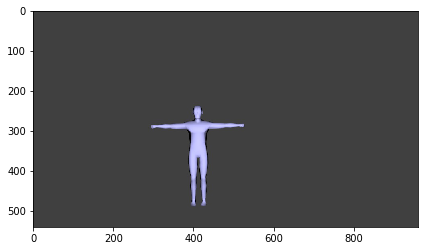

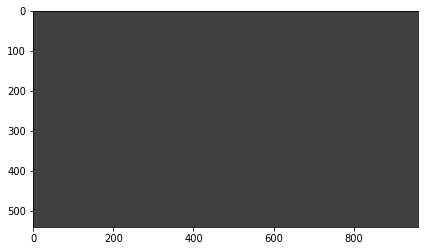

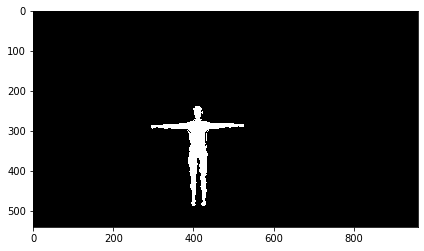

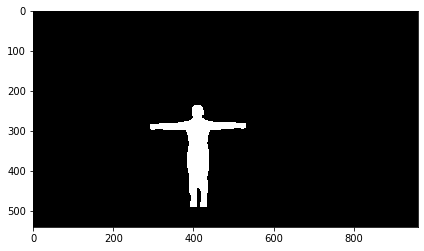

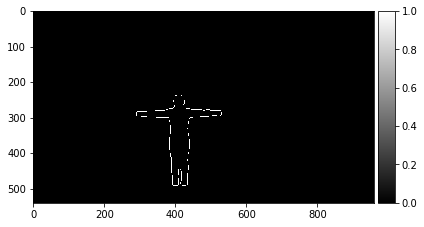

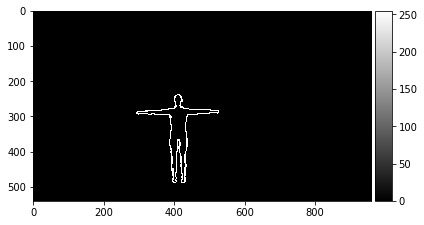

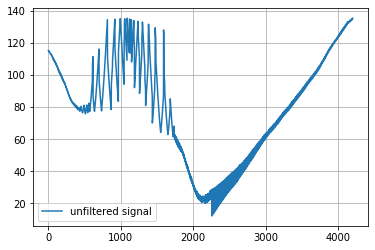

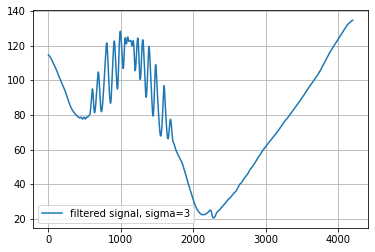

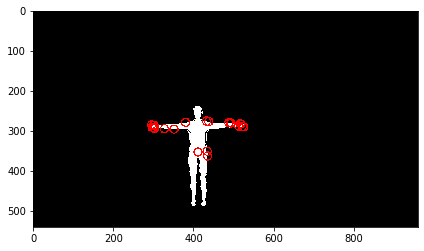

In [47]:
#main
functions_sequence()